# Linearization Experiments

### Setup:

**Imports, Paths, GPU-Settings and Flags:**

In [2]:
import os
import jax
import pickle as pkl
import jax.numpy as jnp
from jax import random
from flax.training import train_state
from matplotlib import pyplot as plt, colors, cm

from configs.config import get_experiment_config, get_model_config
from src.util.linearization.linearizer import Linearizer
from src.util.linearization.linearization_helpers import LinearizationHelper
from src.data.seq.linear_seq import LinearSequenceDataGenerator
from src.training_init import TrainingInitializer
from src.train import Training
from src.attn import MultiHeadAttention
from src.models.auxiliary_models import LeastSquaresSequenceSolver

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
gpus = jax.devices()

rerun_models = False
rerun_analyses = False
store_results = False

dummy_model_def = 'fully_obs_full_fledged_transformer.6.4.10.50.20.True.False.False.False.0.False.False.0.False.False.False.False'
constr_model_def = lambda dim : f'fully_obs_constructed_transformer.2.1.{4*dim}.{4*dim}.{2*dim}.False.False.False.False.0.False.False.0.False.False.False.False'


path_linearization_results = 'experiment_results/linearization/linearization_results.pkl'
path_constr_weights = 'experiment_results/linearization/linearization_weights_20_params.pkl'
path_lsqvsreg_001 = 'experiment_results/linearization/lsqvsreg_001.pkl'
path_constr_lin = 'experiment_results/linearization/constr_linearized_weights.pkl'

print(f'Running on Devices: {gpus},\nRe-Run Analysis: {rerun_analyses}, \nRe-Run Models: {rerun_models}, \nStore Results: {store_results}')

Running on Devices: [CpuDevice(id=0)],
Re-Run Analysis: False, 
Re-Run Models: False, 
Store Results: False


## Linearization analyses:

### Analyse normalized test loss of linearized models:

In [16]:
model_config_linearization = get_model_config(dummy_model_def)
exp_config_linearization = get_experiment_config('linearize_full', seeds=[1,11,111,1111,11111])

if rerun_analyses:
    linearization_dict = Linearizer(model_config=model_config_linearization,
                                    experiment_config=exp_config_linearization,
                                    constr=False,
                                    special_lrs=None,
                                    linear_lrs=None).run()
    
    if store_results:
        print(f'Storing results in path=\'{path_linearization_results}\'')
        with open(path_linearization_results, 'wb') as handle:
            pkl.dump(linearization_dict, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_linearization_results, 'rb') as handle:
        linearization_dict = pkl.load(handle)
m_lin = jnp.mean(linearization_dict['res_array'], axis = 0)
m_lin = jnp.std(linearization_dict['res_array'], axis = 0)

model:  fully_obs_full_fledged_transformer  layers: 6  heads:  4  embed_dim:  10  seq_len:  50  key_size:  20  pe_kq:  True  pe_emb:  False  laynorm:  False  mlp:  False  dim_mlp:  0  linear:  False  clip:  False  clip_val:  0


### Distill linearized model from softmax transformer trained on constructed tokens to compare weights:

In [7]:
exp_config_linearize_constr = get_experiment_config(experiment='linearize_six', seeds=[1])
(_, optimizer, _, train_module) = TrainingInitializer(model_config=get_model_config(constr_model_def(20)), 
                                                      experiment_config=exp_config_linearize_constr).run()

weight_vis_linearizer = Linearizer(model_config=get_model_config(constr_model_def(20)),
                                   experiment_config=exp_config_linearize_constr,
                                   constr=True,
                                   special_lrs=None,
                                   linear_lrs=None)
get_lin_softmax = weight_vis_linearizer.get_linaerizable_softmaxTF
get_lin_datagen = weight_vis_linearizer.get_data_generator
model_tf_softmax = get_lin_softmax(input_dim=20,
                                   embed_dim=80,  
                                   key_size=40,
                                   seq_len=80,
                                   data_dim=20,
                                   linearize=False,
                                   linear_idx=-1)
data_gen = get_lin_datagen(data_dim=20,
                           seq_len=80,
                           embed_dim=80)

training_seed = 68
rng = jax.random.PRNGKey(training_seed)
rng, test_rng, train_rng = jax.random.split(rng, 3)
if rerun_models:
    softmax_tf_train_module = Training(model=model_tf_softmax,
                                        optimizer=optimizer,
                                        data_generator=data_gen,
                                        interpolate=False,
                                        sensitivity_analysis=False,
                                        batch_size=256,
                                        test_batch_size=256)
    state_softmax_tf, train_rng = softmax_tf_train_module.get_init_state(train_rng, interpol_call=False)
    for epoch_idx in range(100):
        state_softmax_tf, train_rng, test_loss, _, _ = softmax_tf_train_module.train_epoch(epoch=epoch_idx,
                                                                                            state=state_softmax_tf,
                                                                                            rng=train_rng,
                                                                                            test_rng=test_rng,
                                                                                            num_batches_train=100,
                                                                                            interpolate=False)    
    if store_results:
        print(f'Storing results in {path_constr_weights}')
        softmax_params_dict = {'params' : state_softmax_tf.params}
        with open(path_constr_weights, 'wb') as handle:
            pkl.dump(softmax_params_dict, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_constr_weights, 'rb') as handle:
        softmax_params_dict = pkl.load(handle)
    softmax_params = softmax_params_dict['params']
    state_softmax_tf = train_state.TrainState.create(apply_fn=model_tf_softmax.apply, params=softmax_params, tx=optimizer)

if rerun_models:
    lin_params = []
    for LINEARIZATION_INDEX in range(2):
        linear_layer = MultiHeadAttention(masked=True,
                                            embed_dim = int(4*20),
                                            num_heads = 1,
                                            use_softmax = False,
                                            use_bias = False,
                                            key_size = int(2*20),
                                            initializer = get_model_config(constr_model_def(20)).initializer,
                                            interpol=False,
                                            seq_len=4*20,
                                            use_pe_kq=False)
        
        linearization_helper = LinearizationHelper(params_softmax=state_softmax_tf.params,
                                                    model_tf=model_tf_softmax,
                                                    linear_layer=linear_layer,
                                                    data_generator=data_gen,
                                                    num_batches_train=100,
                                                    layer_idx=LINEARIZATION_INDEX)
        
        rng, linear_init_rng, train_rng_linear, test_rng_linear = random.split(rng, 4)
        init_params_rng, init_batch_rng = random.split(linear_init_rng)
        (exmp_input,_),_ = data_gen.get_data(rng=init_batch_rng, batch_size=2)
        _, (activations, _, _, _) = model_tf_softmax.apply({'params': state_softmax_tf.params}, exmp_input)
        params_linear = linear_layer.init({'params': init_params_rng}, activations[LINEARIZATION_INDEX])['params']
        state_linear = train_state.TrainState.create(apply_fn=linear_layer.apply, params=params_linear, tx=optimizer)
        
        for _ in range(150):
            state_linear, train_rng_linear, lin_test_loss = linearization_helper.train_epoch_lin(rng=train_rng_linear,
                                                                                                    state=state_linear,
                                                                                                    test_rng=test_rng_linear)
        lin_params.append(state_linear.params)

else:
    with open(path_constr_lin, 'rb') as handle:
        lin_params = pkl.load(handle)['params_list']

model:  fully_obs_constructed_transformer  layers: 2  heads:  1  embed_dim:  80  seq_len:  80  key_size:  40  pe_kq:  False  pe_emb:  False  laynorm:  False  mlp:  False  dim_mlp:  0  linear:  False  clip:  False  clip_val:  0
model:  fully_obs_constructed_transformer  layers: 2  heads:  1  embed_dim:  80  seq_len:  80  key_size:  40  pe_kq:  False  pe_emb:  False  laynorm:  False  mlp:  False  dim_mlp:  0  linear:  False  clip:  False  clip_val:  0


### Visualize softmax vs. linearized weights:

In [10]:
def visualize_weights(state, 
                      layer_index, 
                      num_heads, 
                      key_size,
                      scale,
                      lin_layer,
                      with_loss=False,
                      loss_level=0.1,
                      store=False,
                      store_path=None):
    '''
    Visualize the weights of a transformer model.
    Args:
        'state' (train_state.TrainState): Flax state for the transformer
        'layer_index' (int): Index of the layer
        'num_heads' (int): Number of heads in the transformer
        'key_size' (int): Size of the key
        'store' (bool): If True, the plot is stored
        'store_path' (str): Path to store the plot
    '''
    params = state
    access_name = f'blocklist_{layer_index}'
    if lin_layer:
        q_weights, k_weights, v_weights, P = tuple([params[proj]['kernel'] 
                                                        for proj in ['q_proj', 'k_proj', 'v_proj', 'o_proj']])
    else:
        q_weights, k_weights, v_weights, P = tuple([params['tf_block'][access_name]['self_attn'][proj]['kernel'] 
                                                            for proj in ['q_proj', 'k_proj', 'v_proj', 'o_proj']])

    W_qs, W_ks, W_vs = tuple([jnp.split(weights, num_heads, axis=1) for weights in [q_weights, k_weights, v_weights]])
    all_KtQs, all_PWvs = [], []
    for head_idx in range(num_heads):
        if with_loss:
            ktq = jnp.matmul(W_qs[head_idx], W_ks[head_idx].T)
            ktq = jnp.where(jnp.abs(ktq) > loss_level*jnp.max(jnp.abs(ktq)), ktq, 0)

            pwv = jnp.matmul(W_vs[head_idx], P[head_idx*key_size:(head_idx+1)*key_size,:])
            pwv = jnp.where(jnp.abs(pwv) > loss_level*jnp.max(jnp.abs(pwv)), pwv, 0)
        else:
            ktq = jnp.matmul(W_qs[head_idx], W_ks[head_idx].T)
            pwv = jnp.matmul(W_vs[head_idx], P[head_idx*key_size:(head_idx+1)*key_size,:])
        all_KtQs.append(ktq)
        all_PWvs.append(pwv)

    min_head = lambda head_list : min([head.min() for head in head_list])
    max_head = lambda head_list : max([head.max() for head in head_list])

    max_k = max(abs(min_head(all_KtQs)), abs(max_head(all_KtQs)))*scale
    max_p = max(abs(min_head(all_PWvs)), abs(max_head(all_PWvs)))*scale

    norm_KtQ = colors.TwoSlopeNorm(vmin=-max_k, vmax=max_k, vcenter=0)
    norm_PWv = colors.TwoSlopeNorm(vmin=-max_p, vmax=max_p, vcenter=0)

    fig, axs = plt.subplots(2, num_heads, figsize=(4, 8))

    # Create colorbar axes
    cbar_ax_KtQ = fig.add_axes([0.92, 0.55, 0.02, 0.3])
    cbar_ax_PWv = fig.add_axes([0.92, 0.15, 0.02, 0.3])

    im_ktq = []
    im_pwv = []
    for (head_ktq, head_pwv, heads_idx) in zip(all_KtQs, all_PWvs, range(num_heads)):
        im_ktq.append(axs[0].imshow(head_ktq, cmap='RdBu', norm=norm_KtQ))
        axs[0].set_title(f'$W^T_K {{W_Q}}$')
        im_pwv.append(axs[1].imshow(head_pwv, cmap='RdBu', norm=norm_PWv))
        axs[1].set_title(f'$P {{W_V}}$')

    fig.colorbar(im_ktq[0], cax=cbar_ax_KtQ, label="$W^T_K W_Q$")
    fig.colorbar(im_pwv[0], cax=cbar_ax_PWv, label="$P W_V$")

    if store:
        fig.savefig(store_path, bbox_inches='tight', pad_inches=0.1)

    plt.show()

############## Layer  0  ##############
Softmax-Weights:


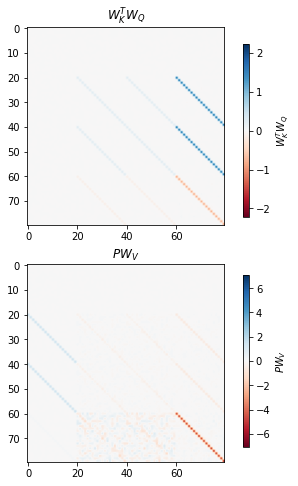

posx and posy should be finite values


Linearized Layer-Weights:


posx and posy should be finite values


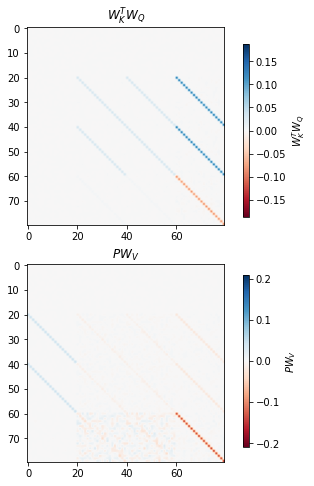

############## Layer  1  ##############
Softmax-Weights:


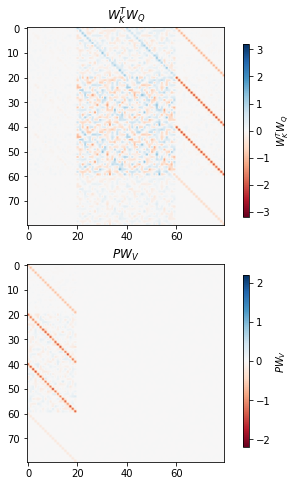

Linearized Layer-Weights:


posx and posy should be finite values
posx and posy should be finite values


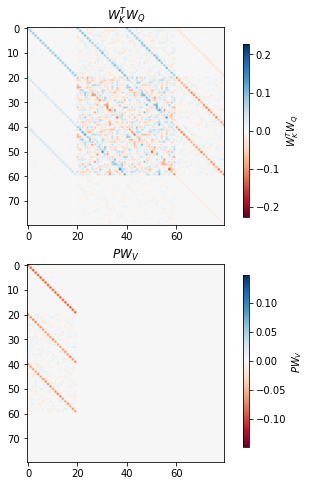

In [12]:
for layer_idx in range(2):
    print('############## Layer ', layer_idx, ' ##############')
    print('Softmax-Weights:')
    visualize_weights(state=state_softmax_tf.params,
                    layer_index=layer_idx,
                    num_heads=1,
                    key_size=40,
                    scale=1.5,
                    lin_layer=False,
                    store=False,
                    store_path=None)
    print('Linearized Layer-Weights:')
    visualize_weights(state=lin_params[layer_idx],
                      layer_index=layer_idx,
                      num_heads=1,
                      key_size=40,
                      scale=1.5,
                      lin_layer=True,
                      store=False,
                      store_path=None)

### Least squares sequence solver vs. Softmax kernel regression:

Helper Functions and Softmax kernel regression implementation:

In [20]:
def get_data_generator(data_dim:int, 
                       seq_len:int,
                       noise:float) -> LinearSequenceDataGenerator:
    '''
        Returns a DataGenerator with the specified parameters.
        Args:
            'data_dim' (int): The data dimension.
            'seq_len' (int): The sequence length.
            'emb_dim' (int): Size of the constructed embeddings e.g.: [0,x_i,x_i,x_{i-1}]
        Returns:
            ConstructedFullSeqGenerator: The ConstructedFullSeqGenerator following the specifications.
    '''
    linseq_d =  LinearSequenceDataGenerator(seq_len=seq_len,
                                            data_dim=data_dim,
                                            obs_dim=data_dim,
                                            range=1,
                                            noise=noise,
                                            noise_obs=0.0,
                                            data_clip=1000,
                                            eye_obs=True)
    return linseq_d

def softmax_kernel(dot_products: jnp.ndarray, beta: float = 1.0) -> jnp.ndarray:
    weights = jax.nn.softmax(beta * dot_products, axis=-1)
    return weights

def compute_dot_products(X: jnp.ndarray) -> jnp.ndarray:
    dot_products = jnp.dot(X, X.T)
    return dot_products

def nn_regression_single_sequence(X: jnp.ndarray, beta: float = 1.0) -> jnp.ndarray:
    seq_len, dim = X.shape
    predictions = jnp.zeros((seq_len, dim))
    dot_products = compute_dot_products(X)
    for t in range(1, seq_len):
        weights = softmax_kernel(dot_products[:t, t], beta)
        past_X = X[1:t+1] 
        weighted_sum = jnp.sum(weights[:, None] * past_X, axis=0)
        predictions = predictions.at[t].set(weighted_sum)
    return predictions

def mse_loss(preds: jnp.ndarray, targets: jnp.ndarray) -> jnp.ndarray:
    bs, sl, d = preds.shape
    return (jnp.sum((targets - preds)**2)/(2*bs*sl*d))

Run Experiment:

In [27]:
if rerun_analyses:
    seeds = [1,11,111,1111,11111]
    dimensions = [4,6,10,20,40,60]
    batch_size = 128
    noise = 0.01
    all_results = jnp.zeros(shape=(len(seeds), 2, len(dimensions)))

    for seed_idx, seed in enumerate(seeds):
        res_reg = []
        res_lsq = []
        for dim_idx, dim in enumerate(dimensions):
            seq_len = 4*dim
            data_generator = get_data_generator(data_dim=dim,
                                                seq_len=seq_len,
                                                noise=noise)
            
            (X,y),_ = data_generator.get_data(jax.random.PRNGKey(seed), batch_size)
            
            min_lsq_loss = 1000
            for lamb in jnp.linspace(0.0001,10,40):
                lsq_solver = LeastSquaresSequenceSolver(approximator='None',
                                                        seq_len=seq_len,
                                                        apx_steps=20,
                                                        lamb=lamb)

                lsq_pred = lsq_solver.predict(data=X, shifted_data=jnp.concatenate([jnp.expand_dims(X[:, 0, :], 1)*0, X], axis=1)[:, :-1, :])
                min_lsq_loss = min(min_lsq_loss, mse_loss(lsq_pred, y))
            print('dim: ', dim, ', LSQ: ', min_lsq_loss, ' with lambda: ', lamb)
            res_lsq.append(min_lsq_loss)
            all_results = all_results.at[seed_idx,0,dim_idx].set(min_lsq_loss)

            min_reg_loss = 1000
            min_beta = 0
            for beta in jnp.linspace(0.0001,4,40):
                predictions = jax.vmap(nn_regression_single_sequence, in_axes=(0,None))(X, beta)
                if mse_loss(predictions, y) < min_reg_loss:
                    min_beta = beta
                min_reg_loss = min(min_reg_loss, mse_loss(predictions, y))
            res_reg.append(min_reg_loss)
            all_results = all_results.at[seed_idx,1,dim_idx].set(min_reg_loss)
            print('dim: ', dim, ', Softmax_kernel_reg.: ', min_reg_loss, ' with beta: ', min_beta)
    
    if store_results:
        print(f'Storing results in path=\'{path_lsqvsreg_001}\'')
        with open(path_lsqvsreg_001, 'wb') as handle:
            pkl.dump({'all_results': all_results}, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_lsqvsreg_001, 'rb') as handle:
        all_results = pkl.load(handle)['all_results']

## Visualize Results: 
**(For visualization of linearized vs. softmax weights see previous section)**

In [28]:
linearization_loss_results = linearization_dict['res_array']
m = jnp.mean(linearization_loss_results, axis=0)
s = jnp.std(linearization_loss_results, axis=0)

mean_lsq = jnp.mean(all_results[:,0,:], axis=0)
mean_reg = jnp.mean(all_results[:,1,:], axis=0)
std_lsq = jnp.std(all_results[:,0,:], axis=0)
std_reg = jnp.std(all_results[:,1,:], axis=0)

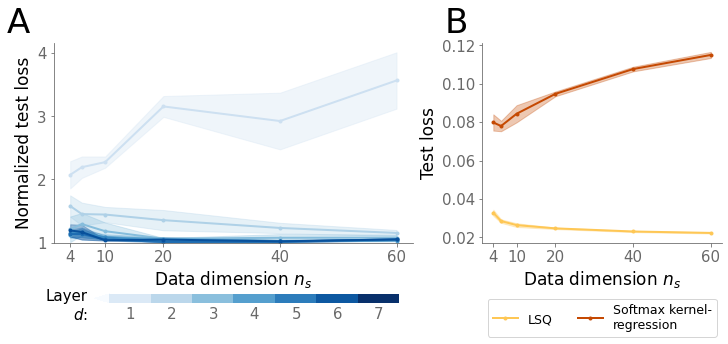

In [34]:
def plot_linearization(res_m:jnp.ndarray,
                       res_s:jnp.ndarray,
                       mean_reg,
                       std_reg,
                       mean_lsq,
                       std_lsq):

    plt.rcParams.update({'font.size': 15})
    plt.rc('axes', labelsize=17)
    plt.rcParams.update({"text.usetex": False})

    num_graphs = res_m.shape[-1]
    colormap_sm = plt.get_cmap('Blues', 100)
    subplot_cols = [colormap_sm(i) for i in [10+(80//num_graphs)*(k+1) for k in range(num_graphs)]]

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), gridspec_kw={'width_ratios': [1.5,1]}, layout='constrained')
    ax0, ax1 = axs

    for layer_idx in range(res_m.shape[-1]):
        ax0.plot([4,6,10,20,40,60], res_m[:,layer_idx], color=subplot_cols[layer_idx], linewidth=2, marker='.', label=f'Layer ${layer_idx}$')
        ax0.fill_between([4,6,10,20,40,60],#range(res_m.shape[0]),
                        (res_m[:,layer_idx] - res_s[:,layer_idx]),
                        (res_m[:,layer_idx] + res_s[:,layer_idx]),
                        color=subplot_cols[layer_idx],
                        alpha=0.3)

    c_lsq = plt.get_cmap('YlOrBr', 100)(36)
    ax1.plot([4,6,10,20,40,60], mean_lsq, linewidth=2, marker='.', label='LSQ', color=c_lsq)
    ax1.fill_between([4,6,10,20,40,60],#range(mean_lsq.shape[0]),
                        (mean_lsq - std_lsq),
                        (mean_lsq + std_lsq),
                        color=c_lsq,
                        alpha=0.3)
    c_reg = plt.get_cmap('YlOrBr', 100)(76)
    ax1.plot([4,6,10,20,40,60], mean_reg, linewidth=2, marker='.', label='Softmax kernel-\nregression', color=c_reg)
    ax1.fill_between([4,6,10,20,40,60],#range(mean_reg.shape[0]),
                        (mean_reg - std_reg),
                        (mean_reg + std_reg),
                        color=c_reg,
                        alpha=0.3)

    # Data dimensions and their corresponding positions
    data_dimensions = [4, 10, 20, 40, 60]
    positions = [4,10,20,40,60]  # Custom spaced positions

    ax0.set_xticks(positions)
    ax0.set_xticklabels(data_dimensions)

    ax1.set_xticks(positions)
    ax1.set_xticklabels(data_dimensions)

    ax0.tick_params(axis='x', colors='dimgray')
    ax0.tick_params(axis='y', colors='dimgray')
    ax0.spines['right'].set_visible(False)
    ax0.spines['top'].set_visible(False)
    ax0.spines['bottom'].set_color('dimgray')
    ax0.spines['left'].set_color('dimgray')
    ax0.set_xlabel('Data dimension $n_s$')
    ax0.set_ylabel('Normalized test loss')
    ax0.set_ylim(1,)

    ax1.tick_params(axis='x', colors='dimgray')
    ax1.tick_params(axis='y', colors='dimgray')
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_color('dimgray')
    ax1.spines['left'].set_color('dimgray')
    ax1.set_xlabel('Data dimension $n_s$')
    ax1.set_ylabel('Test loss')

    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(0.83, 0), loc="upper center",
               bbox_transform=fig.transFigure, ncol=4, fontsize='small', frameon=True)

    # Colorbar:
    box = ax0.get_position()
    cbar_height = 2*0.015
    space_between = 0.0
    cbar_offset = 0.16
    cbar_ax1 = fig.add_axes([box.x0+0.00, box.y0 - cbar_offset, box.width, cbar_height])

    cmap = colormap_sm
    bounds = [1, 2, 3, 4, 5, 6, 7, 8]
    norm = colors.BoundaryNorm(bounds, cmap.N, extend='min')
    cs1 = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), orientation='horizontal', cax=cbar_ax1)

    mid_points = [(bounds[i] + bounds[i + 1]) / 2 for i in range(len(bounds)-1)]
    cs1.set_ticks(mid_points)
    cs1.set_ticklabels(["$1$", "$2$", "$3$", "$4$", "$5$", "$6$", '$7$'], color='dimgray')

    cbar_ax1.set_frame_on(False)
    cbar_ax1.xaxis.set_tick_params(size=0)
    label_y_position = box.y0 - cbar_offset - (cbar_height / 2) - space_between / 2
    fig.text(box.x0 - 0.01, label_y_position+0.005, 'Layer\n$d$:', va='center', ha='right', rotation='horizontal')

    label_size = 34  # Size of the labels
    axs[0].text(-0.13, 1.18, 'A', transform=axs[0].transAxes, fontsize=label_size, va='top')
    axs[1].text(-0.16, 1.18, 'B', transform=axs[1].transAxes, fontsize=label_size, va='top')
    axs[0].set_ylim(1,)

    if store_results:
        fig.savefig('linearization_results.pdf', bbox_inches='tight', pad_inches=0.1)
    plt.show()

plot_linearization(res_m=m,
                   res_s=s,
                   mean_lsq=mean_lsq,
                   mean_reg=mean_reg,
                   std_lsq=std_lsq,
                   std_reg=std_reg)